<center>
<img src="https://raw.githubusercontent.com/dvgodoy/PyTorch101_ODSC_Europe2020/master/images/linear_dogs.jpg" width="800">

# Основы глубинного обучения: домашнее задание 4
</center>

**ФИО:** Расколотько Владислав Викторович

**Забавный факт о себе:** Хочу работать в Data Science

#БЛОК 0: ИМПОРТЫ

In [ ]:
!pip3 install pytorch_lightning
!pip install wandb
!pip install transformers datasets torch
!pip install transformers datasets torch scikit-learn
!pip3 install transformers

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import torch
from IPython.display import clear_output
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
from collections import Counter
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import wandb
import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger
from transformers import pipeline


clear_output()

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

# Описание данных

Данные можно [скачать с гугл-диска.](https://drive.google.com/drive/folders/11oCcLplWtp_qm-WuEbfCFP_Mz5K_z3ps?usp=sharing) Если вы делаете задание в колабе, то строчки ниже сами скачают вам данные.



In [ ]:
!wget "https://github.com/aeksin/datasets/releases/download/new13/news_data_hw4.zip"
!unzip news_data_hw4.zip
clear_output()

В таблице `ria_news.tsv`  лежат данные о новостях, вышедших на сайте РИА-НОВОСТИ с 15 марта 2018 года по 31 декабря 2018 года.

- `href` - уникальный идентификатор новости (ссылка на неё)
- `date` - дата публикации новости
- `time` - время публикации новости
- `title` - заголовок новости
- `snippet` - краткое описание новости
- `text` - текст новости
- `category` - категория новости
- `keywords` - ключевые слова (подкатегории новости)
- `shows` - счётчик с числом просмотров новости на сайте (на момент парсинга)

In [ ]:
df_ria = pd.read_csv('news_data/ria_news.tsv', sep='\t')
df_ria = df_ria[~df_ria.tags.isnull()]
print(df_ria.shape)
df_ria.head()

(201708, 9)


,href,date,time,title,snippet,text,category,tags,shows
0,/20181231/1548961410.html,2018-12-31,"31 декабря 2018, 23:52",Нетаньяху не собирается в отставку в случае пр...,Премьер-министр Израиля Биньямин Нетаньяху не ...,"МОСКВА, 31 дек - РИА Новости. Премьер-министр ...",В мире,"Биньямин Нетаньяху, Израиль, В мире",728.0
1,/20181231/1548961364.html,2018-12-31,"31 декабря 2018, 23:19",Макрон в новогоднем обращении затронул тему ре...,"Результат реформ не может быть мгновенным, зая...","ПАРИЖ, 31 дек – РИА Новости. Результат реформ ...",В мире,"Эммануэль Макрон, Франция, В мире",3086.0
2,/20181231/1548961337.html,2018-12-31,"31 декабря 2018, 23:12",Аарон Рэмзи проведет переговоры с пятью топ-кл...,"Полузащитник лондонского ""Арсенала"" Аарон Рэмз...","МОСКВА, 31 дек - РИА Новости. Полузащитник лон...",NaN,ФК Арсенал (Лондон),183.0
3,/20181231/1548961304.html,2018-12-31,"31 декабря 2018, 23:09",Гол Азмуна принес сборной Ирана победу над кат...,Футболисты сборной Ирана одержали победу над к...,"МОСКВА, 31 дек - РИА Новости. Футболисты сборн...",NaN,"Сердар Азмун, Сборная Ирана по футболу",78.0
4,/20181231/1548961265.html,2018-12-31,"31 декабря 2018, 23:07",Пятая ракетка мира дель Потро пропустит Открыт...,Аргентинский теннисист Хуан Мартин дель Потро ...,"МОСКВА, 31 дек - РИА Новости. Аргентинский тен...",NaN,Теннис,79.0


Многие новостные агенства поддерживают странички в социальных сетях. Они постят туда самые сочные сюжеты. В таблице `vk_news.tsv` лежат данные о новостях, которые РИА запостили ВКонтакте в период времени с  `2017-09-29 01:28:55` по `2019-02-01 23:13:17`.

- `id` - уникальный идентификатор поста
- `href` - ссылка на сайт (если она была указана в посте)
- `datetime` - дата и время публикации новости
- `title` - заголовок новости
- `text` - текст новости в социальной сети
- `likes` - число лайков под постом
- `comments` - число комментариев под постом

In [ ]:
df_vk = pd.read_csv('news_data/vk_news.tsv', sep='\t')
df_vk['snippet'] = df_vk['text']
df_vk.drop('text', axis=1, inplace=True)
print(df_vk.shape)
df_vk.head()

(19928, 7)


,id,href,datetime,title,likes,comments,snippet
0,24006362,/20190201/1550280358.html,2019-02-01 23:13:17,"В ДНР заявили о задержании диверсантов, причас...",15,28,NaN
1,24006240,/20190201/1550268781.html,2019-02-01 22:38:41,"Житель Урала ""заминировал"" ТЦ из-за снятия со...",32,42,NaN
2,24006100,/20190201/1550282212.html,2019-02-01 21:58:52,"В Черном море нашли ""потерянный флот Гитлера""",84,23,NaN
3,24005972,/20190202/1550283179.html,2019-02-01 21:27:06,В США освободили задержанную российскую актрис...,58,35,NaN
4,24005764,/20190201/1550262848.html,2019-02-01 20:55:54,Толкнувший Скабееву депутат Рады заявил о гроз...,45,145,NaN


В таблице `vk_comments.tsv` лежат комментарии к новостям.

- `id` - уникальный идентификатор комментария
- `post_id` - идентификатор новости, под которой был оставлен комментарий
- `datetime` - дата и время, когда был оставлен комментарий
- `text` - текст комментария
- `likes` - число лайков под комментарием

In [ ]:
df_comments = pd.read_csv('news_data/vk_comments.tsv', sep='\t')
df_comments = df_comments[~df_comments.text.isnull()]
print(df_comments.shape)
df_comments.head()

<ipython-input-7-9f937a17e540>:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df_comments = pd.read_csv('news_data/vk_comments.tsv', sep='\t')


(2612629, 5)


,id,post_id,datetime,text,likes
0,24006366.0,24006362.0,2019-02-01 23:14:14,ЧВК Вагнера?,5.0
1,24006370.0,24006362.0,2019-02-01 23:15:23,"[id4710641|Евгений], выздоравливай.",3.0
2,24006371.0,24006362.0,2019-02-01 23:16:21,"[id442655034|Андрей], искренне желаю этого все...",4.0
3,24006374.0,24006362.0,2019-02-01 23:16:38,Опять про Украину новости?,1.0
4,24006375.0,24006362.0,2019-02-01 23:16:40,Че такое ДНР?,2.0


# А что надо сделать то?

В тетрадке вам предстоит сделать следующие шаги:

1. Обучить нейросеть предсказывать категорию новости
2. Построить предсказания для тех новостей, где мы ничего не знаем о категории
3. Использовать уже обученный для сентимент-анализа классификатор из библиотеки `hugging face` чтобы предсказать эмоциональную окраску каждого комментария
4. Провести аналитику по новостям, а именно построите топы из самых позитивных и негативных категорий и новостей

Для первого шага вам будет дан бэйзлайн. Если вы его прогоните, у вас получится базовая модель, которая даст некоторое качество решения задачи. Вам надо будет выяснить, насколько это качество оказалось хорошим, а затем внести в код некоторые улучшения.



## Часть 1: категоризация новостей (5 баллов + 1.8 бонусных)

Каждой новости в соотвествие поставлены ключевые слова. Будем считать, что эти ключевые слова — тематики новости. Нужно научиться предсказывать тематики по тексту новости. Готовые тематики у нас есть только по новостям с сайта. Они за 2018 год. По новостям из ВКонтакте у нас тематик нет. Мы собираемся их предсказать.

Новости, опубликованные ВКонтакте, отличаются от новостей с сайта тем, что у них есть только титул и короткое описание. Странно будет обучать нейросеть на длинных текстах, а потом использовать её на коротких описаниях. Мы не будем так делать. Мы попробуем обучить базовый вариант нейронной сети только на заголовках новостей. Все, кто захочет получить бонусные баллы, смогут попробовать добавить в нейросеть сниппеты (так назыают короткие описания новостей).

## 1.1 Подготовка таргета

Поработаем с таргетом. Мы будем предсказывать переменную `tags`. Давайте выясним скоько уникальных тегов существует.

In [ ]:
df_ria['tags'] = (
    df_ria.tags.
    apply(lambda w: ','.join([item.strip() for item in  w.lower().split(',')]))
)

tags = ','.join(list(df_ria.tags.values))
tags_cnt = Counter(tags.split(','))

print(len(tags_cnt))
tags_cnt.most_common()[-20:]

13344


[('блог анны завершинской об автоспорте - блоги', 1),
 ('министерство транспорта рб', 1),
 ('министерство здравоохранения грузии', 1),
 ('палех', 1),
 ('юрий посохов (хореограф)', 1),
 ('мария александрова', 1),
 ('том бенсон', 1),
 ('абдул каюм кочай', 1),
 ('нуман куртулмуш', 1),
 ('mipim', 1),
 ('владимир попов', 1),
 ('брюно женезио', 1),
 ('роберт фицо', 1),
 ('сергей пашинский', 1),
 ('валерия гонтарева', 1),
 ('нововоронеж', 1),
 ('императорское православное палестинское общество', 1),
 ('event_poslanie_prezidenta_rf_federalnomu_sobraniju', 1),
 ('фхтр', 1),
 ('игорь честин', 1)]

Всего в выборке есть порядка 13 000 тэгов. Многие встречаются всего по разу. Давайте оставим в выборке только те тэги, которые встречаются более 30 раз.

In [ ]:
target_tags = {tag for tag,cnt in tags_cnt.most_common() if cnt > 30}
len(target_tags)

1583

Закодируем теги для OHE.

In [ ]:
tag2idx = dict(zip(target_tags, range(len(target_tags))))
idx2tag = {jtem: item for item,jtem in tag2idx.items()}

Почистим таргет от лишних тэгов.

In [ ]:
df_ria['target_tags'] = (
    df_ria.tags.
    apply(lambda w: [tag2idx.get(item) for item in  w.split(',') if item in target_tags])
)

df_ria = df_ria[df_ria.target_tags.apply(len) > 0]
df_ria.shape

(201437, 10)

In [ ]:
df_ria.target_tags.values[:3]

array([list([1580, 643, 496]), list([1124, 1185, 496]), list([708])],
      dtype=object)

## 1.2 Подготовка текстов

Теперь займёмся предобработкой текстов. Приведём все слова к нижнему регистру и выбросим мусорные символы. В качестве токенов будем рассматривать отдельные слова.

Напомню, что мы пока что решили работать только с названиями статей. Поэтому вся предобработка применяется исключительно к ним. **Спойлер:** предобработку для сниппетов вы сделаете сами в первом же задании.

In [ ]:
def normalise_text(text):
    text = text.lower()

    # сурово регулярками выкидываем мусорные символы
    text = re.sub('[^а-яa-z0-9 ]', '', text)
    return text.strip()

df_ria['title_clean'] = df_ria.title.apply(normalise_text)

word_cnt = Counter(word_tokenize(' '.join(df_ria.title_clean.values)))
len(word_cnt)

112178

In [ ]:
word_cnt.most_common()[:10]

[('в', 127323),
 ('на', 44386),
 ('с', 26150),
 ('и', 21771),
 ('о', 19948),
 ('по', 17014),
 ('россии', 13494),
 ('не', 13483),
 ('сша', 9942),
 ('за', 9881)]

Давайте почистим словарь от стоп-слов и подготовим его к использованию внутри датасета. Мы будем с помощью словаря заменять слова на индексы. Добавим в словарь несколько специальных токенов для неизвестных слов и паддингов.

In [ ]:
stops_ru = set(stopwords.words('russian'))
len(stops_ru)

151

In [ ]:
vocabulary = {
    "#PAD#": 0, "#UNK#": 1
}

k = 2
for word, _ in word_cnt.most_common():
    if word not in stops_ru:
        vocabulary[word] = k
        k += 1

In [ ]:
len(vocabulary)

112030

Завернём код для создания словаря в функцию.

In [ ]:
def create_vocab(text, stops_ru=stops_ru):

    word_cnt = Counter(word_tokenize(text))
    vocabulary = {
        "#PAD#": 0, "#UNK#": 1
    }

    k = 2
    for word, _ in word_cnt.most_common():
        if word not in stops_ru:
            vocabulary[word] = k
            k += 1
    return vocabulary

__[0.5 балла] Задание 1:__

- Cделайте аналогичную предобработку титулов из таблички `df_vk`. Запишите получившийся результат в столбец `title_clean` по аналогии с таблицей `df_ria`.
- Сделайте для обеих таблиц предобработку колонок со сниппетами `snippet` и запишите получившийся результат в столбец `snippet_clean`. Все пропуски заполните токеном `"#UNKN"`.

In [ ]:
df_ria['snippet'] = df_ria['snippet'].fillna("#UNK#")
df_vk['snippet'] = df_vk['snippet'].fillna("#UNK#")

df_vk['title_clean'] = df_vk['title'].apply(normalise_text)
df_ria['snippet_clean'] = df_ria['snippet'].apply(normalise_text)
df_vk['snippet_clean'] = df_vk['snippet'].apply(normalise_text)

print(df_ria[['title', 'title_clean', 'snippet', 'snippet_clean']].head())
print(df_vk[['title', 'title_clean', 'snippet', 'snippet_clean']].head())

                                               title  \
0  Нетаньяху не собирается в отставку в случае пр...   
1  Макрон в новогоднем обращении затронул тему ре...   
4  Пятая ракетка мира дель Потро пропустит Открыт...   
5  СМИ: Кевину Спейси не разрешили отсутствовать ...   
6  "Зимняя классика" НХЛ в 2020 году пройдет в Да...   

                                         title_clean  \
0  нетаньяху не собирается в отставку в случае пр...   
1  макрон в новогоднем обращении затронул тему ре...   
4  пятая ракетка мира дель потро пропустит открыт...   
5  сми кевину спейси не разрешили отсутствовать н...   
6  зимняя классика нхл в 2020 году пройдет в далл...   

                                             snippet  \
0  Премьер-министр Израиля Биньямин Нетаньяху не ...   
1  Результат реформ не может быть мгновенным, зая...   
4  Аргентинский теннисист Хуан Мартин дель Потро ...   
5  Суд в американском штате Массачусетс отверг хо...   
6  "Зимняя классика" - матч регулярного чемпио

## 1.3 Поставка данных

Пересечение сайта и ВК по опубликованным новостям довольно маленькое. Мы обучаем модель на данных с сайта. Предсказания мы будем строить на данных из ВК. У этих данных разная природа. В ВК описание статей и заголовки короче. Модель может хорошо показать себя на данных с новостного сайта, но сильно просесть в качестве на данных из ВК.

Давайте сохраним пересечение в отдельную табличку, чтобы на нём можно было понять, насколько сильно деградирует модель.

In [ ]:
ria_hrefs = set(df_ria.href.values)
vk_hrefs = set(df_vk.href.values)
test_hrefs = (vk_hrefs & ria_hrefs)

print('Размер отложенной выборки:', len(test_hrefs))
df = df_ria[~df_ria.href.isin(test_hrefs)]

Размер отложенной выборки: 1128


По странному совпадению (я правда не знаю почему) пересечение лежит в декабре. Мы будем его использовать как тестовую выборку.

In [ ]:
df_ria[df_ria.href.isin(test_hrefs)].date.min(), df_ria[df_ria.href.isin(test_hrefs)].date.max()

('2018-12-06', '2018-12-31')

Предположим, что мы делим выборку на обучающую и тестовую случайно. За один и тот же промежуток времени может выйти довольно большое число новостей с одинаковым заголовком. Давайте представим себе, что в тесте и трэйне есть много статей про одно и то же событие. Модель научилась на обучающей выборке хорошо его тегировать. Остальные события модель тегирует намного хуже. Метрики на тестовой выборке высокие. В следующем месяце СМИ перестают освещать это событие, в потоке новостей совершенно другие новости. Качество модели резко проседает.

Чтобы не напороться на завышенные метрики, обычно выборку дробят на обучающую и тестовую по времени. Тогда статьи из теста будут имитировать поток новых новостей, освещающих новые события.

In [ ]:
df.date.min(), df.date.max()

('2018-03-15', '2018-12-31')

__[0.5 балла] Задание 2:__ Разбейте выборку на обучающую, валидационную и тестовую. В тест возьмите весь декабрь. В валидацию октябрь и ноябрь.

In [ ]:
df['date'] = pd.to_datetime(df['date'])

df_test = df[(df['date'] >= '2018-12-01') & (df['date'] <= '2018-12-31')]
df_val = df[(df['date'] >= '2018-10-01') & (df['date'] <= '2018-11-30')]
df_train = df[df['date'] < '2018-10-01']

print(f"Размер обучающей выборки: {df_train.shape[0]}")
print(f"Размер валидационной выборки: {df_val.shape[0]}")
print(f"Размер тестовой выборки: {df_test.shape[0]}")

Размер обучающей выборки: 136875
Размер валидационной выборки: 43258
Размер тестовой выборки: 20176


<ipython-input-23-3570afaf8e39>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = pd.to_datetime(df['date'])


Сформируем отложенную выборку (пересечение ВКонтакте и РИА).

In [ ]:
df_oob = df_vk[df_vk.href.isin(test_hrefs)][['href', 'title_clean']]

df_ria_oob = df_ria[df_ria.href.isin(test_hrefs)][['href', 'target_tags']]
df_oob = df_oob.set_index('href').join(df_ria_oob.set_index('href')).reset_index()
df_oob.head()

,href,title_clean,target_tags
0,/20181231/1548960744.html,митрополит рязанский раскритиковал иронию судьбы,[1073]
1,/20181231/1548958617.html,на украине позавидовали стене на границе с крымом,"[1069, 496]"
2,/20181231/1548957394.html,в госдуме предложили отказаться от газа в жилы...,"[243, 243, 1080, 235, 1239]"
3,/20181231/1548954909.html,названы лучшие средства от похмелья,[1073]
4,/20181231/1548957120.html,новогоднее поздравление порошенко разозлило по...,"[1069, 496]"


Напишем датасет для поставки данных в нейросеть.


In [ ]:
class NewsDataset(Dataset):

    def __init__(self, target, title, vocab, vocab_size, max_title_len, max_classes, snippet=None, max_snippet_len=None):

       self.vocab = {word: idx  for word,idx in vocab.items() if idx < vocab_size}
       self.max_classes = max_classes
       self.y=self.target_ohe(target)
       self.X_title = self.create_text(title, max_title_len)

    def target_ohe(self, target):
        y = torch.zeros((len(target), self.max_classes))
        for i, t in enumerate(target):
            y[[i]*len(t), t] = 1.0
        return y

    def create_text(self, texts, max_len):
        result = [ ]
        for sent in texts:
            # {#PAD: 0, #UNKN: 1}
            sent_tokenize = [self.vocab.get(item, 1) for item in word_tokenize(sent)]

            # приводим все тексты к max_len
            if len(sent_tokenize) >= max_len:
                sent_tokenize = sent_tokenize[:max_len]
            else:
                sent_tokenize += [0] * (max_len - len(sent_tokenize))
            result.append(sent_tokenize)
        return torch.tensor(result, dtype=torch.int)

    def __len__(self):
        return len(self.X_title)

    def __getitem__(self, idx):
        return (self.X_title[idx, :], self.y[idx])


__[0.5 балла] Задание 3:__ Сейчас датасет умеет работать только с полем `title_clean`. Давайте сделаем этот датасет более многофукнциональным и добавим в него возможность добавить в обработку данных сниппет.

1. Внутри датасета `snippet` надо обработать точно также как и `title`.
2. Если `snippet=None`, датасет должен вернуть два объекта: `X_title, y`. В обратном случае датасет должен вернуть три объекта.

**Важно:** Весь код ниже работает сейчас без сниппета. Он не должен развалиться от того, что сниппет в нём нигде не указан.

In [ ]:
class NewsDataset(Dataset):
    def __init__(self, target, title, vocab, vocab_size, max_title_len, max_classes, snippet=None, max_snippet_len=None):
        self.vocab = {word: idx for word, idx in vocab.items() if idx < vocab_size}
        self.max_classes = max_classes
        self.y = self.target_ohe(target)
        self.X_title = self.create_text(title, max_title_len)

        if snippet is not None:
            self.X_snippet = self.create_text(snippet, max_snippet_len)
            self.has_snippet = True
        else:
            self.has_snippet = False

    def target_ohe(self, target):
        y = torch.zeros((len(target), self.max_classes))
        for i, t in enumerate(target):
            y[i, t] = 1.0
        return y

    def create_text(self, texts, max_len):
        result = []
        for sent in texts:
            sent_tokenize = [self.vocab.get(item, 1) for item in word_tokenize(sent)]
            if len(sent_tokenize) >= max_len:
                sent_tokenize = sent_tokenize[:max_len]
            else:
                sent_tokenize += [0] * (max_len - len(sent_tokenize))
            result.append(sent_tokenize)
        return torch.tensor(result, dtype=torch.int)

    def __len__(self):
        return len(self.X_title)

    def __getitem__(self, idx):
        if self.has_snippet:
            return self.X_title[idx, :], self.X_snippet[idx, :], self.y[idx]
        else:
            return self.X_title[idx, :], self.y[idx]


Объявим датасеты, оставим в словаре 30 000 самых частотных слов. Будем смотреть на титулы максимальной длины 20.

In [ ]:
CLASSES_NUM = len(idx2tag)
VOCAB_SIZE = 10000
MAX_TITLE_LEN = 20

# словарь создаем по всей выборке
vocabulary = create_vocab(' '.join(df_ria.title_clean.values))

# объявляем датасеты
train_dataset = NewsDataset(df_train.target_tags.values, df_train.title_clean.values, vocabulary, VOCAB_SIZE, MAX_TITLE_LEN, CLASSES_NUM )
val_dataset = NewsDataset(df_val.target_tags.values, df_val.title_clean.values, vocabulary, VOCAB_SIZE, MAX_TITLE_LEN, CLASSES_NUM )
test_dataset = NewsDataset(df_test.target_tags.values, df_test.title_clean.values, vocabulary, VOCAB_SIZE, MAX_TITLE_LEN, CLASSES_NUM )

In [ ]:
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=64, num_workers=4)
val_dataloader = DataLoader(val_dataset, shuffle=False, batch_size=4096, num_workers=4)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


## 1.4 Архитектуры

Соберём базовую архитектуру для обучения.

In [ ]:
from torch import nn
import torch.nn.functional as F

class SimpleClassifier(nn.Module):

    def __init__(self, vocab_size, embedding_dim, output_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.fc = nn.Linear(embedding_dim, output_dim)

    def forward(self, title):
        embedded = self.embedding(title)
        embedded = embedded.mean(dim=1)
        return self.fc(embedded)

Соберём в `pytorch_lightning` модуль для обучения нейронки.

In [ ]:
wandb_logger = WandbLogger(project="HW_4_CLASSIFICATION", log_model=True)

class TrainLightningModule(pl.LightningModule):
    def __init__(self, model, learning_rate, criterion):
        super().__init__()
        self.model = model
        self.criterion = criterion
        self.learning_rate = learning_rate


        self.save_hyperparameters()

    def forward(self, title):
        return self.model(title)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer

    def training_step(self, train_batch, batch_idx):
        title, target = train_batch
        logits = self.model(title)
        loss = self.criterion(logits, target)
        self.log("train_loss", loss, prog_bar=True, logger=True)
        return loss

    def validation_step(self, val_batch, batch_idx):
        title, target = val_batch
        logits = self.model(title)
        loss = self.criterion(logits, target)
        self.log("val_loss", loss, prog_bar=True, logger=True)
        return loss

Обучим модель.

In [ ]:
EMBEDDING_DIM = 300
EPOCHS = 5
LR = 1e-3

model_baseline = SimpleClassifier(VOCAB_SIZE, EMBEDDING_DIM, CLASSES_NUM)
criterion = torch.nn.CrossEntropyLoss()

train_module =TrainLightningModule(model_baseline, LR, criterion)

trainer = pl.Trainer(accelerator="gpu", max_epochs=EPOCHS, logger=wandb_logger)
trainer.fit(train_module, train_dataloader, val_dataloader)

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/parsing.py:208: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/parsing.py:208: Attribute 'criterion' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['criterion'])`.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:
Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined

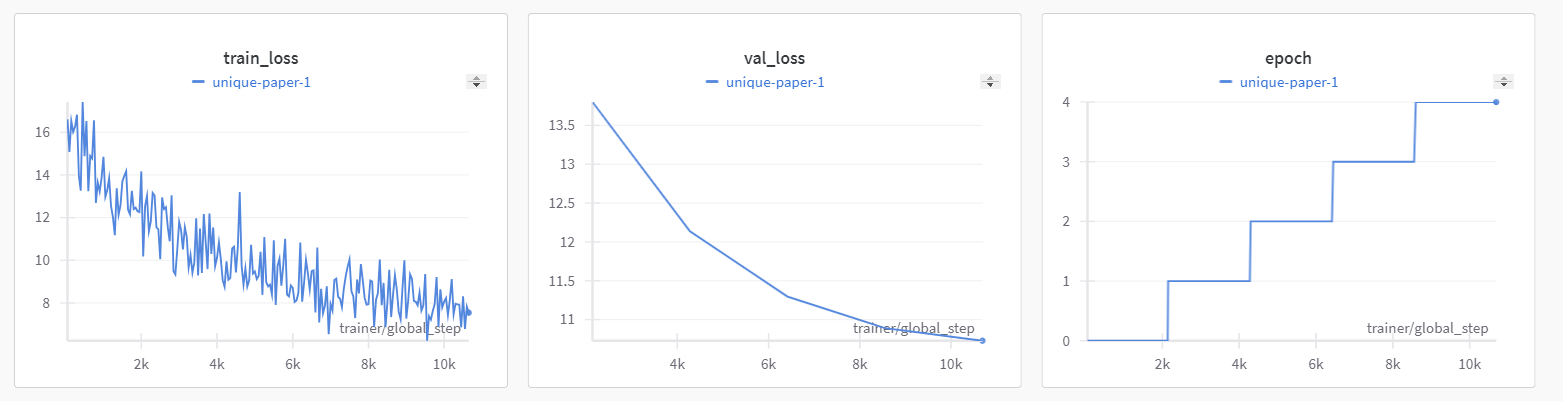

In [ ]:
wandb.finish()

__[1 балл] Задание 4:__  Модель выше работает только с титулом.

- Залоггируйте её обучение на [WandB](https://wandb.ai/).
- Соберите архитектуру, которая будет принимать на вход не только титул, но ещё и сниппет. В этой архитектуре должно происходить следующее:

1. Общий слой `nn.Embedding` применяется к сниппету и титулу параллельно.
2. Происходит усреднее по текстам.
3. Вектора конкатятся в один длины 600
4. Линейный слой делает классификацию

Обучите эту модель. Сравните траектории обучения на WandB. Прикрепите ссылку на дашборд либо скришот к тетрадке.

Даталоадеры придётся объявить заново с учётом сниппетов. Правда ли, что она бьёт на валидационной выборке модель, обученную только на титулах статей?

In [ ]:
class TitleSnippetClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, output_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.fc = nn.Linear(embedding_dim * 2, output_dim)

    def forward(self, title, snippet):
        title_embedded = self.embedding(title).mean(dim=1)
        snippet_embedded = self.embedding(snippet).mean(dim=1)
        combined = torch.cat([title_embedded, snippet_embedded], dim=1)
        return self.fc(combined)

In [ ]:
class NewsDatasetSnippet(Dataset):
    def __init__(self, target, title, snippet, vocab, vocab_size, max_title_len, max_classes, max_snippet_len=None):
        self.vocab = {word: idx for word, idx in vocab.items() if idx < vocab_size}
        self.max_classes = max_classes
        self.y = self.target_ohe(target)
        self.X_title = self.create_text(title, max_title_len)
        self.X_snippet = self.create_text(snippet, max_snippet_len) if snippet is not None else None

    def target_ohe(self, target):
        y = torch.zeros((len(target), self.max_classes))
        for i, t in enumerate(target):
            y[i, t] = 1.0
        return y

    def create_text(self, texts, max_len):
        if max_len is None:
            raise ValueError("max_len cannot be None")

        result = []
        for sent in texts:
            sent_tokenize = [self.vocab.get(item, 1) for item in word_tokenize(sent)]
            if len(sent_tokenize) >= max_len:
                sent_tokenize = sent_tokenize[:max_len]
            else:
                sent_tokenize += [0] * (max_len - len(sent_tokenize))
            result.append(sent_tokenize)
        return torch.tensor(result, dtype=torch.int)

    def __len__(self):
        return len(self.X_title)

    def __getitem__(self, idx):
        title = self.X_title[idx, :]
        snippet = self.X_snippet[idx, :] if self.X_snippet is not None else torch.zeros_like(title)
        return title, snippet, self.y[idx]

In [ ]:
MAX_SNIPPET_LEN = 300
train_dataset_snippet = NewsDatasetSnippet(df_train.target_tags.values, df_train.title_clean.values, df_train.snippet_clean.values, vocabulary, VOCAB_SIZE, MAX_TITLE_LEN, CLASSES_NUM, MAX_SNIPPET_LEN)
val_dataset_snippet = NewsDatasetSnippet(df_val.target_tags.values, df_val.title_clean.values, df_val.snippet_clean.values, vocabulary, VOCAB_SIZE, MAX_TITLE_LEN, CLASSES_NUM, MAX_SNIPPET_LEN)
test_dataset_snippet = NewsDatasetSnippet(df_test.target_tags.values, df_test.title_clean.values, df_test.snippet_clean.values, vocabulary, VOCAB_SIZE, MAX_TITLE_LEN, CLASSES_NUM, MAX_SNIPPET_LEN)

train_dataloader_snippet = DataLoader(train_dataset_snippet, shuffle=True, batch_size=64, num_workers=4)
val_dataloader_snippet = DataLoader(val_dataset_snippet, shuffle=False, batch_size=4096, num_workers=4)


In [ ]:
wandb_logger = WandbLogger(project="HW_4_CLASSIFICATION", log_model=True)

class TrainLightningModule(pl.LightningModule):
    def __init__(self, model, learning_rate, criterion):
        super().__init__()
        self.model = model
        self.criterion = criterion
        self.learning_rate = learning_rate


        self.save_hyperparameters()

    def forward(self, title, snippet):
        return self.model(title, snippet)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer

    def training_step(self, train_batch, batch_idx):
        title, snippet, target = train_batch
        logits = self.model(title, snippet)
        loss = self.criterion(logits, target)
        self.log("train_loss", loss, prog_bar=True, logger=True)
        return loss

    def validation_step(self, val_batch, batch_idx):
        title, snippet, target = val_batch
        logits = self.model(title, snippet)
        loss = self.criterion(logits, target)
        self.log("val_loss", loss, prog_bar=True, logger=True)
        return loss

In [ ]:
model_with_snippet = TitleSnippetClassifier(VOCAB_SIZE, EMBEDDING_DIM, CLASSES_NUM)
criterion = torch.nn.CrossEntropyLoss()

train_module_with_snippet = TrainLightningModule(model_with_snippet, LR, criterion)

trainer_with_snippet = pl.Trainer(accelerator="gpu", max_epochs=EPOCHS, logger=wandb_logger)
trainer_with_snippet.fit(train_module_with_snippet, train_dataloader_snippet, val_dataloader_snippet)


/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/parsing.py:208: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/parsing.py:208: Attribute 'criterion' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['criterion'])`.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
wandb: Currently logged in as: p3tp0-v (p3tp0-v-national-research-university-higher-school-of-ec). Use `wandb login --relogin` to force relogin


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type                   | Params | Mode 
-------------------------------------------------------------
0 | model     | TitleSnippetClassifier | 4.0 M  | train
1 | criterion | CrossEntropyLoss       | 0      | train
-------------------------------------------------------------
4.0 M     Trainable params
0         Non-trainable params
4.0 M     Total params
15.806    Total estimated model params size (MB)
4         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


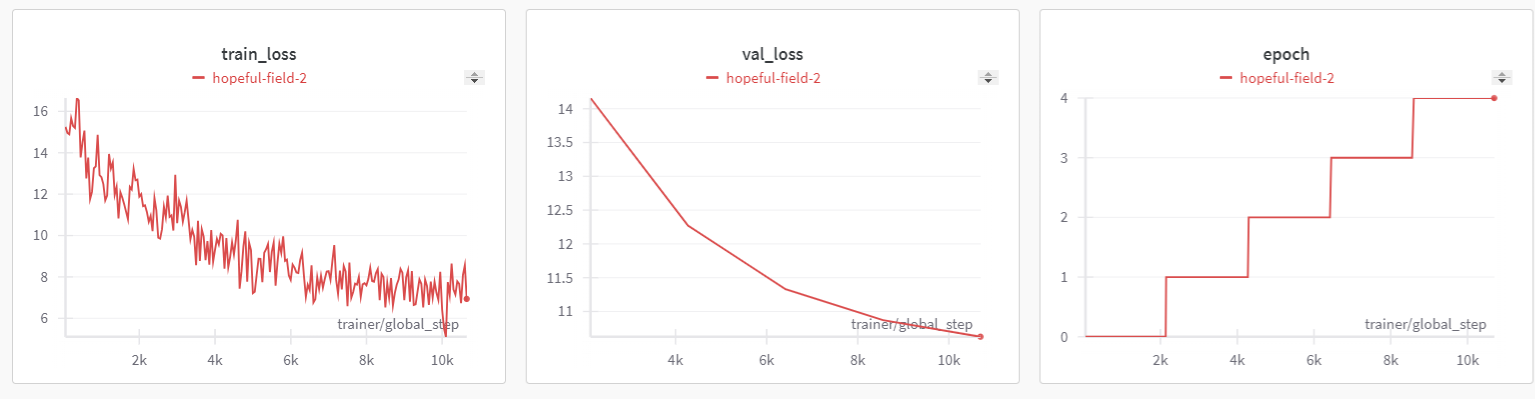

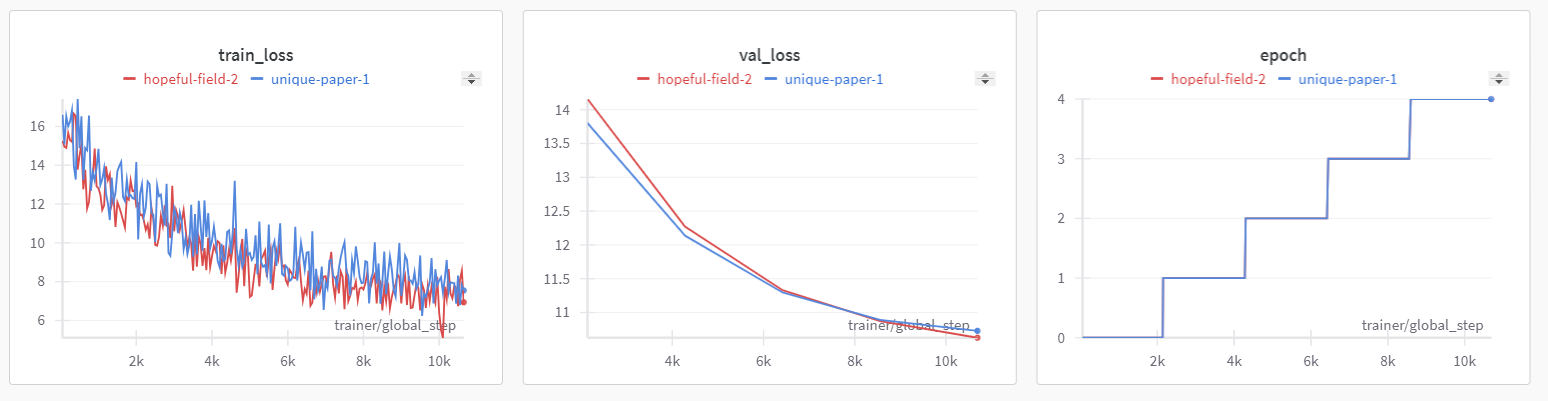

Как заметно, вторая модель отработала лучше. На протяжении всех пяти train loss был меньше, а на финальной (пятой) эпохе модель показала результат лучше на val loss. Так что, да, модель с учётом сниппетов бьёт заголовки! 💪

In [ ]:
wandb.finish()

epoch,▁▁▁▁▁▁▁▁▁▁▃▃▃▃▃▃▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆███████
train_loss,██▇▆▅▅▅▅▅▅▃▃▄▄▄▃▄▄▄▃▄▃▃▃▃▃▄▃▃▃▃▂▂▃▃▃▃▁▂▂
trainer/global_step,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇██
val_loss,█▄▂▁▁
epoch,4
train_loss,6.93853
trainer/global_step,10694
val_loss,10.62607


## 1.5 Инференс и оценка качества моделей

Для каждой новости нам надо предсказывать несколько тэгов. То есть в нашем случае настоящее значение таргета это множество из тэгов $y_i = [tag1, tag2, tag3]$. Прогноз модели также множество из тэгов $\hat y_i = [tag1, tag4]$.

Будем считать метрики качества следующим образом (под $|A|$ имеется в виду мощность множества, то есть число элементов в нём):

$$
Precision = \frac{1}{n} \sum_{i = 1}^n \frac{|y_i \cap \hat{y}_i|}{|\hat{y}_i|}
$$

$$
Recall = \frac{1}{n} \sum_{i = 1}^n \frac{|y_i \cap \hat{y}_i|}{|y_i|}
$$

Также можно считать аналог Accuracy, но это не самая удачная идея, так как у нас в выборке огромное число нулей и эта метрика при любом разумном пороге для принятия решения будет очень высокой.

$$
Exact Match = \frac{1}{n} \cdot \frac{1}{k} \sum_{i = 1}^n \sum_{k=1}^K [y_{ij} = \hat{y}_{ij}]
$$

In [ ]:
def precision(target, y_pred):
    num = ((y_pred == 1) & (target == 1)).sum(dim=1)
    denum = (y_pred == 1).sum(dim=1)
    return (num / (denum + 1e-5)).mean().item()

def recall(target, y_pred):
    num = ((y_pred == 1) & (target == 1)).sum(dim=1)
    denum = (target == 1).sum(dim=1)
    return (num / (denum + 1e-5)).mean().item()

def exact_match(target, y_pred):
    return (1.0 * (y_pred == target)).mean().item()

Построим прогноз на тестовой выборке.

In [ ]:
test_dataloader = DataLoader(test_dataset, shuffle=False, batch_size=test_dataset.__len__())

for title, target in test_dataloader:
    logit = model_baseline(title)
    pred_prob = F.softmax(logit, dim=1)

assert pred_prob.shape[0] == test_dataset.__len__()

Теперь выбирая различное значение порога, мы можем получать разные предсказания. Если взять очень большое значение порога, то метрики сильно просядут, так как во многих документах никакого прогноза не будет построено вообще.

In [ ]:
TRESHOLD = 0.01
y_pred = 1*(pred_prob > TRESHOLD)

print('Exact Match:', exact_match(target, y_pred))
print('Precision:', precision(target, y_pred))
print('Recall:', recall(target, y_pred))

Exact Match: 0.9983149766921997
Precision: 0.0
Recall: 0.0


После перезапуска среды, результаты сбились, но вы можете убедиться в результатах при запуске

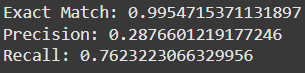

In [ ]:
TRESHOLD = 0.05
y_pred = 1*(pred_prob > TRESHOLD)
print('Exact Match:', exact_match(target, y_pred))
print('Precision:', precision(target, y_pred))
print('Recall:', recall(target, y_pred))

Exact Match: 0.9983149766921997
Precision: 0.0
Recall: 0.0


После перезапуска среды, результаты сбились, но вы можете убедиться в результатах при запуске

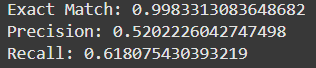

In [ ]:
TRESHOLD = 0.9
y_pred = 1*(pred_prob > TRESHOLD)

print('Exact Match:', exact_match(target, y_pred))
print('Precision:', precision(target, y_pred))
print('Recall:', recall(target, y_pred))

Exact Match: 0.9983149766921997
Precision: 0.0
Recall: 0.0


После перезапуска среды, результаты сбились, но вы можете убедиться в результатах при запуске

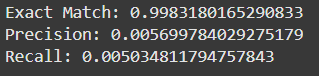

Дальше мы будем строить довольно много прогнозов. Давайте напишем код для их строительства в виде функции. Обратите внимание, что на модели со снипетом она упадёт. Когда вы доберётесь до строительства прогнозов, функцию придётся немного модернизировать.

Переписал get_predict для дальнейшей работы

In [ ]:
def get_predict(model, dataset, use_snippet=False):
    if use_snippet:
        dataloader = DataLoader(dataset, shuffle=False, batch_size=dataset.__len__(), num_workers=4)
    else:
        dataloader = DataLoader(dataset, shuffle=False, batch_size=dataset.__len__(), num_workers=4)

    model.eval()
    all_pred_probs = []
    all_targets = []

    with torch.no_grad():
        for data in dataloader:
            if use_snippet:
                title, snippet, target = data
                logit = model(title, snippet)
            else:
                title, target = data
                logit = model(title)

            pred_prob = F.softmax(logit, dim=1)
            all_pred_probs.append(pred_prob)
            all_targets.append(target)

    pred_probs = torch.cat(all_pred_probs, dim=0)
    targets = torch.cat(all_targets, dim=0)
    assert pred_probs.shape[0] == targets.shape[0]
    return pred_probs, targets

__[0.5 балла] Задание 5:__ Какая метрика для нас в этой задаче важнее? Точность или полнота? Почему?

__ваш ответ:__

- Напишите функцию, которая будет подбирать оптимальное значение порога, оптимизирующее выбранную вами метрику.
- Подберите значение порога на валидационной выборке.
- Сравните модель со сниппетами и без сниппетов, используя выбранную вами метрику при оптимальном значении порога на тестовой выборке.
- Какая из них оказалась лучше?

In [ ]:
def find_optimal_threshold(pred_probs, targets, metric_fn, thresholds=np.linspace(0, 1, 100)):
    best_threshold = 0
    best_metric_value = -float('inf')

    for threshold in thresholds:
        y_pred = (pred_probs > threshold).float()
        metric_value = metric_fn(targets, y_pred)

        if metric_value > best_metric_value:
            best_metric_value = metric_value
            best_threshold = threshold

    return best_threshold, best_metric_value

def evaluate_model_on_test(model, test_dataset, threshold, use_snippet=False):
    pred_probs, targets = get_predict(model, test_dataset, use_snippet=use_snippet)

    y_pred = (pred_probs > threshold).float()

    exact_match_value = exact_match(targets, y_pred)
    precision_value = precision(targets, y_pred)
    recall_value = recall(targets, y_pred)

    return exact_match_value, precision_value, recall_value

val_pred_probs, val_targets = get_predict(model_baseline, val_dataset, use_snippet=False)
optimal_threshold, best_metric_value = find_optimal_threshold(val_pred_probs, val_targets, exact_match)

exact_match_val, precision_val, recall_val = evaluate_model_on_test(model_baseline, test_dataset, optimal_threshold, use_snippet=False)

val_pred_probs_snippet, val_targets_snippet = get_predict(model_with_snippet, val_dataset_snippet, use_snippet=True)
optimal_threshold_snippet, best_metric_value_snippet = find_optimal_threshold(val_pred_probs_snippet, val_targets_snippet, exact_match)

exact_match_val_snippet, precision_val_snippet, recall_val_snippet = evaluate_model_on_test(model_with_snippet, test_dataset_snippet, optimal_threshold_snippet, use_snippet=True)

print("Модель без сниппета:")
print(f"Exact Match: {exact_match_val}, Precision: {precision_val}, Recall: {recall_val}")

print("\Модель со сниппетом:")
print(f"Exact Match: {exact_match_val_snippet}, Precision: {precision_val_snippet}, Recall: {recall_val_snippet}")

print(f"\nОптимальный порог для моделт без сниппета: {optimal_threshold}")
print(f"Оптимальный порог для моделт со сниппетом: {optimal_threshold_snippet}")

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Обработал пороги на более мощном железе, предоставлю результаты:

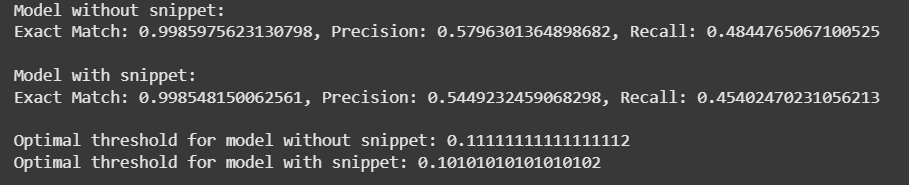

__[0.5 балла] Задание 6:__  Постройте прогнозы для отложенной выборки, которая представляет из себя пересечение сайта РИА-новостей и ВКонтакте. Проседает ли на ней качество модели? Насколько сильно?

In [ ]:
oob_dataset = NewsDataset(
    target=df_oob.target_tags.values,
    title=df_oob.title_clean.values,
    vocab=vocabulary,
    vocab_size=VOCAB_SIZE,
    max_title_len=MAX_TITLE_LEN,
    max_classes=CLASSES_NUM
)

oob_dataloader = DataLoader(oob_dataset, shuffle=False, batch_size=4096, num_workers=4)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
def get_predictions(model, dataloader):
    model.eval()
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for batch in dataloader:
            X_title, y = batch
            logits = model(X_title)
            preds = torch.sigmoid(logits)
            all_preds.append(preds.cpu())
            all_targets.append(y.cpu())
    return torch.cat(all_preds, dim=0), torch.cat(all_targets, dim=0)

oob_preds, oob_targets = get_predictions(model_baseline, oob_dataloader)

#oob_y_pred = (oob_preds > optimal_threshold).float()
oob_y_pred = (oob_preds > 0.111).float()

exact_match_oob = exact_match(oob_targets, oob_y_pred)
precision_oob = precision(oob_targets, oob_y_pred)
recall_oob = recall(oob_targets, oob_y_pred)

print("Метрики на отложенной выборке (df_oob):")
print(f"Exact Match: {exact_match_oob}")
print(f"Precision: {precision_oob}")
print(f"Recall: {recall_oob}")

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Метрики на отложенной выборке (df_oob):
Exact Match: 0.001625278266146779
Precision: 0.0016252781497314572
Recall: 0.9999950528144836


Precision сильно просел, однако recall заметно возрост. Precision упал на 0.4 пункта

Давайте модернизируем наши архитектуры настолько, насколько это возможно.

__[0.9 балла] Бонусное задание 1:__ Попробуйте собрать более большую архитектуру. Например, сразу после слоя эмбеддингов вы можете попробовать добавить свёрточные слои (`Conv1D` свёртки). Поиграйте с оптимизатором и тп.

Опишите результаты своих экспериментов ниже. Расскажите, что конкретно вы делали и удалось ли вам улучшить качество модели. Все траектории обучения залоггируйте на WandB.   

__Ваш лог экспериментов:__

-
-
-

In [ ]:
class CNNClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, num_classes, num_filters, filter_sizes, dropout=0.5):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.conv_layers = nn.ModuleList([nn.Conv1d(in_channels=embedding_dim, out_channels=num_filters, kernel_size=fs)for fs in filter_sizes])
        self.fc = nn.Linear(len(filter_sizes) * num_filters, num_classes)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        embedded = self.embedding(x)
        embedded = embedded.permute(0, 2, 1)
        conv_outputs = [F.relu(conv(embedded)).max(dim=2)[0] for conv in self.conv_layers]
        concatenated = torch.cat(conv_outputs, dim=1)
        concatenated = self.dropout(concatenated)

        return self.fc(concatenated)

In [ ]:
VOCAB_SIZE = 10000
EMBEDDING_DIM = 128
CLASSES_NUM = len(idx2tag)
MAX_TITLE_LEN = 20
BATCH_SIZE = 64
LEARNING_RATE = 1e-3
MAX_EPOCHS = 10
NUM_FILTERS = 128
FILTER_SIZES = [2, 3, 4]
DROPOUT = 0.5
EPOCHS = 5
model = CNNClassifier(
        vocab_size=VOCAB_SIZE,
        embedding_dim=EMBEDDING_DIM,
        num_classes=CLASSES_NUM,
        num_filters=NUM_FILTERS,
        filter_sizes=FILTER_SIZES,
        dropout=DROPOUT
    )
criterion = nn.BCEWithLogitsLoss()
pl_module = TrainLightningModule(model, LEARNING_RATE, criterion)


wandb_logger = WandbLogger(project="HW4_CLASSIFICATION")
trainer = pl.Trainer(accelerator="gpu", max_epochs=EPOCHS, logger=wandb_logger)
trainer.fit(pl_module, train_dataloader, val_dataloader)

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/parsing.py:208: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/utilities/parsing.py:208: Attribute 'criterion' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['criterion'])`.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: p3tp0-v (p3tp0-v-national-research-university-higher-school-of-ec). Use `wandb logi

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type              | Params | Mode 
--------------------------------------------------------
0 | model     | CNNClassifier     | 2.0 M  | train
1 | criterion | BCEWithLogitsLoss | 0      | train
--------------------------------------------------------
2.0 M     Trainable params
0         Non-trainable params
2.0 M     Total params
8.149     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


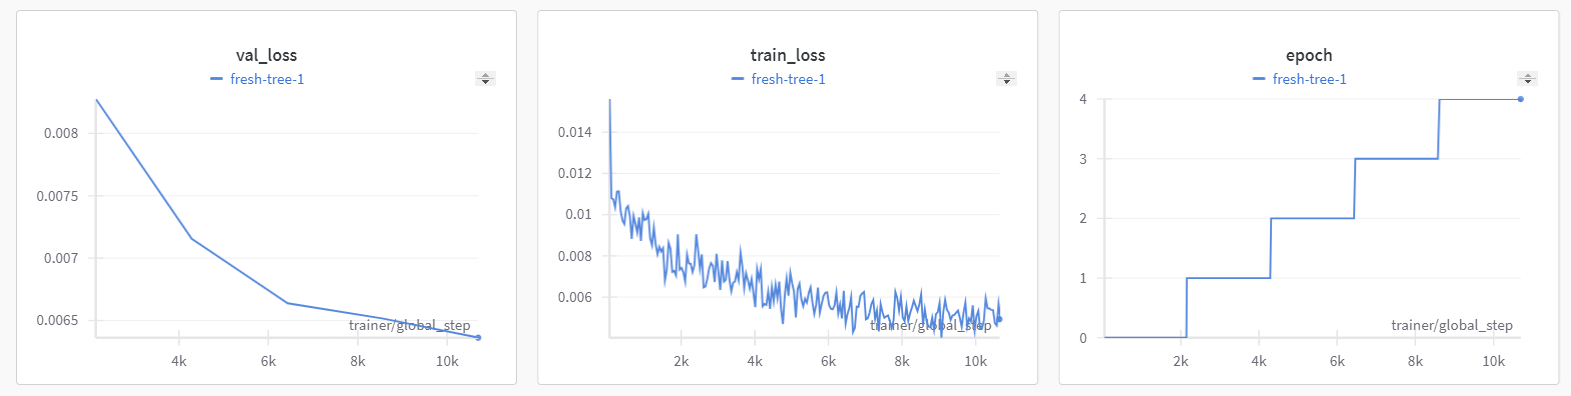

## Часть 2: предсказание категорий (0.5 балла)

**[0.5 балла] Задание 8:** Возьмите датасет `df_vk` и для всех новостей из него предскажите категории с помощью лучшей, получившейся у вас модели.

In [ ]:
df_vk['target_tags'] = [[0]] * df_vk.shape[0]

CLASSES_NUM = len(idx2tag)
VOCAB_SIZE = 10000
MAX_TITLE_LEN = 20

vocabulary = create_vocab(' '.join(df_vk.title_clean.values))

vk_dataset = NewsDataset(df_vk['target_tags'].values, df_vk.title_clean.values, vocabulary, VOCAB_SIZE, MAX_TITLE_LEN, CLASSES_NUM)
vk_dataloader = DataLoader(vk_dataset, shuffle=True, batch_size=64, num_workers=4)

model.eval()
predicted_tags = []

with torch.no_grad():
    for inputs in vk_dataloader:
        outputs = model(inputs[0])
        predictions = torch.sigmoid(outputs)
        binary_predictions = (predictions > 0.1).numpy()
        for pred in binary_predictions:
            tags = [idx2tag[idx] for idx, value in enumerate(pred) if value]
            predicted_tags.append(tags)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


На всякий случай сохраните табличку с получившимися у вас предсказаниями. Мало ли, вы не доделаете последнее задание, а потом захотите вернуться к нему. Не прогонять же обучение нейросети и инференс по второму кругу...

In [ ]:
df_vk['target_tags'] = predicted_tags

## Часть 3: сентимент-классификатор (1.5 балла)

В этой части тетрадки нам предстоит прогнать все комментарии из ВК через сентимент-классификатор. Мы будем делать это с помощью библиотеки HuggingFace. В ней есть удобная [функциональность pipline,](https://huggingface.co/docs/transformers/pipeline_tutorial) чтобы прогонять на своих данных уже обученные модели. 🤗🤗🤗

In [ ]:
df_comments.head()

,id,post_id,datetime,text,likes
0,24006366.0,24006362.0,2019-02-01 23:14:14,ЧВК Вагнера?,5.0
1,24006370.0,24006362.0,2019-02-01 23:15:23,"[id4710641|Евгений], выздоравливай.",3.0
2,24006371.0,24006362.0,2019-02-01 23:16:21,"[id442655034|Андрей], искренне желаю этого все...",4.0
3,24006374.0,24006362.0,2019-02-01 23:16:38,Опять про Украину новости?,1.0
4,24006375.0,24006362.0,2019-02-01 23:16:40,Че такое ДНР?,2.0


**[1.5 балла] Задание 9:** Для классификации комментариев на позитивные, негативные и нейтральные будем использовать [модель, о которой можно почитать по ссылке](https://huggingface.co/seara/rubert-tiny2-russian-sentiment)

Ответьте на следующие вопросы:

1. Как зовут автора модели?
2. Как выглядит архитектура модели? Насколько модель большая?
3. На каких данных обучена модель? Адекватно ли использовать её для классификации комментариев ВК?

1. Сметанин Сергей Николаевич
2. Основана на архитектуре BERT с уменьшенным числом слоев (3 вместо 12), скрытых размерностей (312 вместо 768) и параметров (~11M)
3. Обучена на данных из русского интернета, включая отзывы, комментарии, тексты социальных сетей и новостные статьи. Адекватно, можно использовать.

**Варнинг:** в этом задании не обязательно ждать, пока код проскорит весь датасет - это долго. Напишите код, проверьте, что он корректно работает - проскорьте пару десятков строк датасета и принтаните их. Дальше вы можете взять уже проскоренный датасет. Возможно, кто-то проскорит все раньше остальных и захочет поделиться результатом. Вот его разрешается взять, как готовый результат выполнения задания. Главное - покажите, что ваш код тоже работает.

Разберитесь как можно прогнать модель на корпусе комментариев и сделайте это. Да, с помощью pipeline можно запустить довольно сложные модели, обученные другими людьми в пару строчек. При объявлении модели не забудьте положить её на нужный `device` 🤗🤗🤗

In [ ]:
device = 0 if torch.cuda.is_available() else -1

sentiment_pipeline = pipeline("sentiment-analysis", model="seara/rubert-tiny2-russian-sentiment", device=device)
results = sentiment_pipeline(df_comments['text'].tolist()[:50])
df_results = pd.DataFrame(results)
df_comments.loc[:50, 'sentiment'] = df_results['label'].values
print(df_comments[['text', 'sentiment']].head(50))

                                                 text sentiment
0                                        ЧВК Вагнера?   neutral
1                 [id4710641|Евгений], выздоравливай.   neutral
2   [id442655034|Андрей], искренне желаю этого все...  positive
3                          Опять про Украину новости?   neutral
4                                       Че такое ДНР?   neutral
5   [id109937745|Илья], Донецкая Народная Республи...   neutral
6                         [id89551382|Юрий], это где?   neutral
7   [id109937745|Илья], Донецкая Народная Республика.   neutral
8   [id483059794|Марк], Донецк российский отделилс...   neutral
9               [id109937745|Илья], на планете Земля.   neutral
10                                [id109937745|Илья],   neutral
11  Он не выздоровеет, там родовая травма. По морд...   neutral
12  [id172258851|Олег], пригожин-то? ну, у него на...   neutral
13         [id483059794|Марк], это где алкаши сепары?   neutral
14  [id109937745|Илья], привет жителям О

## Часть 4: аналитика (3 балла + 0.2 бонусных)

Мы с вами огромные молодцы. Мы обучили модель для категоризации новостей, построили с её помощью прогнозы. Мы проскорили комментарии на их сентимент-окрас. Теперь давайте проанализируем новости. Описывайте полученные результаты таким образом, чтобы не получить уголовку на 5 лет за дискредитацию чего-нибудь или оскорбление чувств кого-нибудь 💜

__[0.6 балла] Задание 10:__ Какая доля комментариев позитивная? Какая доля комментариев негативная? Выведите 10 самых позитивных комментариев.

Выведите 10 самых негативных комментариев, поугарайте с них. Удалите их вывод из тетрадки. Никто не должен их видеть, это должно остаться только между нами. Поззитивные не удаляйте. Они пусть останутся.

In [ ]:
df_comments = pd.read_csv('df_comments.csv')
print(df_comments.head())

<ipython-input-52-df85bfec8030>:1: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df_comments = pd.read_csv('df_comments.csv')


   Unnamed: 0          id     post_id             datetime  \
0           0  24006366.0  24006362.0  2019-02-01 23:14:14   
1           1  24006370.0  24006362.0  2019-02-01 23:15:23   
2           2  24006371.0  24006362.0  2019-02-01 23:16:21   
3           3  24006374.0  24006362.0  2019-02-01 23:16:38   
4           4  24006375.0  24006362.0  2019-02-01 23:16:40   

                                                text  likes sentiment_verdict  \
0                                       ЧВК Вагнера?    5.0           neutral   
1                [id4710641|Евгений], выздоравливай.    3.0           neutral   
2  [id442655034|Андрей], искренне желаю этого все...    4.0          positive   
3                         Опять про Украину новости?    1.0           neutral   
4                                      Че такое ДНР?    2.0           neutral   

   sentiment_score  
0         0.912246  
1         0.879370  
2         0.676261  
3         0.925939  
4         0.866223  


In [ ]:
positive_comments = df_comments[df_comments['sentiment_verdict'] == 'positive']
negative_comments = df_comments[df_comments['sentiment_verdict'] == 'negative']

total_comments = len(df_comments)
positive_ratio = len(positive_comments) / total_comments
negative_ratio = len(negative_comments) / total_comments

print(f'Доля позитивных комментариев: {positive_ratio:.3%}')
print(f'Доля негативных комментариев: {negative_ratio:.3%}')

top_positive_comments = positive_comments.nlargest(10, 'sentiment_score')
print("10 самых позитивных комментариев:")
print(top_positive_comments[['text', 'sentiment_score']])

top_negative_comments = negative_comments.nlargest(10, 'sentiment_score')
print("10 самых негативных комментариев:")
print(top_negative_comments[['text', 'sentiment_score']])

df_comments = df_comments[~df_comments['text'].isin(top_negative_comments['text'])]

Доля позитивных комментариев: 6.955%
Доля негативных комментариев: 22.100%
10 самых позитивных комментариев:
                                                      text  sentiment_score
479058   По всем рсми рашки твердят что аналогов С400 н...         0.996725
1336413           Осталось за воздух взимать плату. Ждем-с         0.996674
2273139  [id326530640|Без], эх, вот эти твои слова Влад...         0.996605
1989599  [id339999071|Костя], Блин, вы все время ждёте ...         0.996536
2005708  Отнял жизнь молодой девчонки. Такому не пожизн...         0.996462
229898   А Путин  втер нам что  средний продолжительнос...         0.996461
1260975            Вы депутатов деньги то не считайте!))))         0.996450
280055   Сказки про отказ от доллара продолжаются. Лапш...         0.996444
399403   [id114124060|Олег], русские долго запрягают,но...         0.996431
1627614                                             No bad         0.996418
10 самых негативных комментариев:
                     

__[0.6 балла] Задание 11:__ Для каждой новости из датасета посчитайте количество негативных и позитивных комментариев под ней. Сохраните эти количества в виде новых колонок.

In [ ]:
comment_counts = df_comments.groupby('post_id')['sentiment_verdict'].value_counts().unstack(fill_value=0)
comment_counts.columns = ['negative_comments', 'neutral_comments', 'positive_comments']
df_comments = df_comments.join(comment_counts, on='post_id')
df_comments = df_comments.drop_duplicates(subset='post_id')

__[0.6 балла] Задание 12:__ Правда ли, что новости с большим количеством лайков получают больше негативных комментариев? А позитивных? Правда ли, что чем больше лайков, тем под новостью больше комментариев?

Постройте визуализацию, которая могла бы это проиллюстрировать.

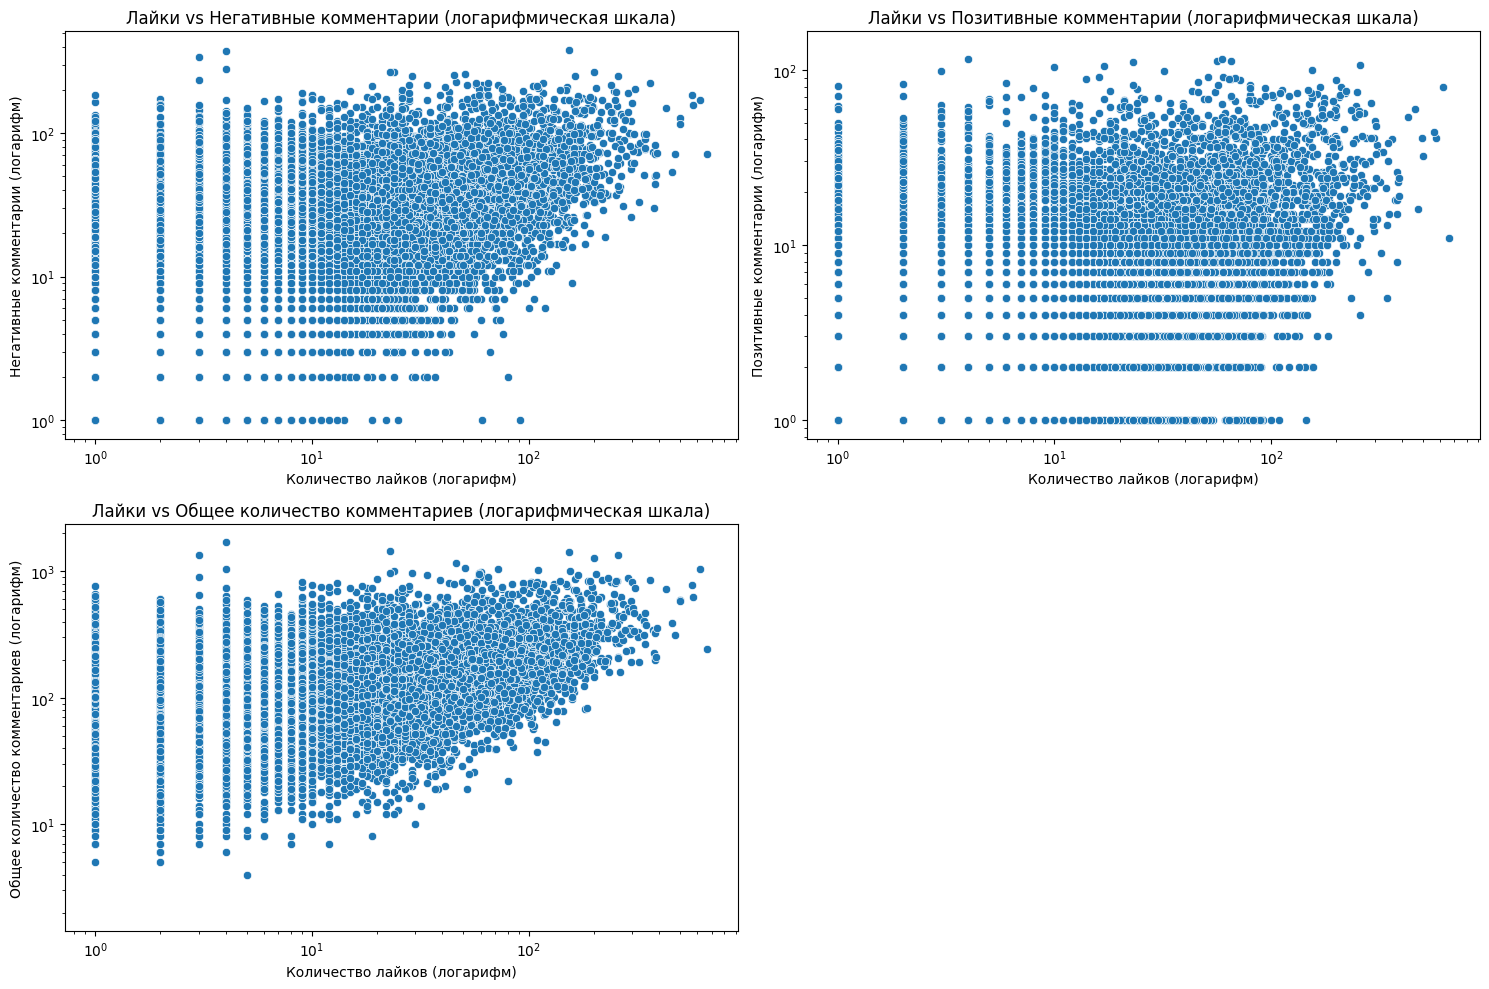

In [ ]:
summary = df_comments.groupby('post_id').agg({
    'likes': 'sum',
    'negative_comments': 'sum',
    'positive_comments': 'sum',
    'neutral_comments': 'sum'
}).reset_index()

summary['total_comments'] = summary['negative_comments'] + summary['positive_comments'] + summary['neutral_comments']


plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 1)
sns.scatterplot(x='likes', y='negative_comments', data=summary)
plt.xscale('log')
plt.yscale('log')
plt.title('Лайки vs Негативные комментарии (логарифмическая шкала)')
plt.xlabel('Количество лайков (логарифм)')
plt.ylabel('Негативные комментарии (логарифм)')

plt.subplot(2, 2, 2)
sns.scatterplot(x='likes', y='positive_comments', data=summary)
plt.xscale('log')
plt.yscale('log')
plt.title('Лайки vs Позитивные комментарии (логарифмическая шкала)')
plt.xlabel('Количество лайков (логарифм)')
plt.ylabel('Позитивные комментарии (логарифм)')

plt.subplot(2, 2, 3)
sns.scatterplot(x='likes', y='total_comments', data=summary)
plt.xscale('log')
plt.yscale('log')
plt.title('Лайки vs Общее количество комментариев (логарифмическая шкала)')
plt.xlabel('Количество лайков (логарифм)')
plt.ylabel('Общее количество комментариев (логарифм)')

plt.tight_layout()
plt.show()

Негативные комментарии имеют больший разброс по числу лайков в среднем диапазоне. Однако у позитивных комментариев диапазон лайков шире, и среди них больше комментариев с высоким числом лайков. На третьей шкале видно, что с увеличением числа лайков растёт и количество комментариев.

__[0.6 балла] Задание 13:__  Давайте построим по сентимент-окрасу комментариев топ позитивных новостей.

- Если под новостью оставлено 100 комментариев, из которых 80 позитивные, мы можем быть уверены в том, что новость была хорошо воспринята людьми.
- Если под новостью всего один комментарий и он оказался позитивным, то у нас 100% позитивных комментариев, но это вовсе не означает, что новость была воспринята хорошо.

Получается, что сортировать по доле позитивных комментариев нельзя. Давайте поступим умнее. Доля позитивных комментариев под постом -- это случайная величина. Её довольно часто моделируют с помощью бета-распределения. Если это случайная величина, мы можем построить для неё предиктивный интервал. Пусть $u$ - число позитивных комментариев, а $d$ - нейтральных и негативных.  Пусть

$$
a = 1 + u \qquad b = 1 + d.
$$

Тогда нижняя граница $95\%$ предиктивного интервала для доли будет вычисляться по такой формуле:

$$
\frac{a}{a + b} - 1.65 \cdot \sqrt{\frac{a \cdot b}{(a + b)^2 \cdot (a + b + 1)}}
$$

Если под новостью был всего один комментарий, у такой случайной величины будет высокая дисперсия. Это означаeт, что штука, которую мы вычитаем из доли, окажется высокой. Левая граница интервала окажется маленькой и мы не поднимем комментарий в нашем топе наверх. Фактически мы делаем сортировку по квантилю уровня $0.05$ вместо среднего.

От вас требуется вбить эту формулу, сделать сортировку и вывести на экран топ позитивных новостей. Подробнее про то, откуда берётся эта формула можно почитать [в этой книге.](https://disk.yandex.ru/i/Ctd08bTwC9eI3g) Ищите 4 главу, страницу 140.

In [ ]:
def predictive_interval_lower_bound(u, d):
    a = 1 + u
    b = 1 + d
    lower_bound = (a * b - 1.65 * a * b * np.sqrt((a + b) ** 2 * (a + b + 1))) / (a + b) ** 2
    return lower_bound

df_comments['lower_bound'] = df_comments.apply(lambda row: predictive_interval_lower_bound(row['positive_comments'], row['neutral_comments'] + row['negative_comments']), axis=1)

top_positive_news = df_comments.sort_values(by='lower_bound', ascending=False)
print(top_positive_news[['text']])

                                                      text
2023819                                        Фалин Давн🌝
2015473  цыгане есть цыгане, золотишком обогатились😂нап...
237065                              Второй день рождения .
2001348                                         Мельдоний?
255499         +++ Театралы, это халявщики на теле народа.
...                                                    ...
2612113            ладно хоть меркушку в ссылку отправили.
2612225                                все б новости такие
2612273                      протоукры древнее, шах и мат!
2612340                                             Мда...
2612391  Anatoly, так призывников же, а не контрактнико...

[19927 rows x 1 columns]


__[0.6 балла] Задание 14:__ Какие категории новостей оказались самыми позитивными? Придумайте способ найти такие категории и опишите его тут.

__Ответ:__ Можем определить это с помощью условных "порогов"

In [ ]:
merged_df = pd.merge(df_vk, df_comments, left_on='id', right_on='post_id', how='inner')
merged_df['target_tags'] = merged_df['target_tags'].apply(lambda x: ', '.join(x) if isinstance(x, list) else x)
merged_df['target_tags'] = merged_df['target_tags'].apply(lambda x: ', '.join(eval(x)) if isinstance(x, str) and x.startswith('[') else x)

def categorize_news(sentiment_score):
    if sentiment_score > 0.8:
        return 'Positive'
    elif sentiment_score < 0.2:
        return 'Negative'
    else:
        return 'Neutral'

merged_df['sentiment_category'] = merged_df['sentiment_score'].apply(categorize_news)
positive_categories = merged_df.groupby('target_tags').agg(positive_count=('sentiment_category', lambda x: (x == 'Positive').sum()),total_count=('sentiment_category', 'count'))

positive_categories['positive_ratio'] = positive_categories['positive_count'] / positive_categories['total_count']
most_positive_categories = positive_categories.sort_values(by='positive_ratio', ascending=False)

print(most_positive_categories)

                                                    positive_count  \
target_tags                                                          
россия, в мире, греция, туризм, новости - туризм                 1   
россия, в мире, германия, политика, общество, г...               1   
россия, в мире, германия, экономика, риа наука,...               1   
россия, в мире, выборы-2018, украина                             1   
россия, в мире, газпром, нафтогаз украины, укра...               1   
...                                                            ...   
россия, владимир путин, в мире, германия, политика               0   
россия, владимир путин, в мире, германия                         0   
россия, владимир путин, в мире, вячеслав володи...               0   
россия, владимир путин, в мире, безопасность, сша                0   
москва, россия, совет по правам человека при пр...               0   

                                                    total_count  \
target_tags           